##  Full Specification Data Analysis

This is a comprehensive, structured examination of the dataset, where all variables (features) are documented, explored, and understood before modeling begins.

### 1. Import Libraries & Load Dataset

We load the raw dataset containing Bitcoin mempool and blockchain metadata for downstream analysis.

In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [5]:
df = pd.read_parquet('../data/raw/extracted_s3.parquet')

df.head()

,timestamp,mempool_blocks_blockSize,mempool_blocks_blockVSize,mempool_blocks_nTx,mempool_blocks_totalFees,mempool_blocks_medianFee,recommended_fee_fastestFee,recommended_fee_halfHourFee,recommended_fee_hourFee,recommended_fee_economyFee,...,mempool_fee_histogram_bin_550_600,mempool_fee_histogram_bin_600_650,mempool_fee_histogram_bin_650_700,mempool_fee_histogram_bin_700_750,mempool_fee_histogram_bin_750_800,mempool_fee_histogram_bin_800_850,mempool_fee_histogram_bin_850_900,mempool_fee_histogram_bin_900_950,mempool_fee_histogram_bin_950_1000,mempool_fee_histogram_bin_1000_plus
0,1741505382,1863701.0,997991.75,1627.0,1898161.0,1.005750,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1743132281,1713032.0,997957.25,4238.0,1955148.0,1.137755,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1741966781,1581944.0,997916.75,3786.0,6082318.0,4.827505,5.0,4.0,3.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1741739981,1995221.0,997832.00,3199.0,2070408.0,1.987956,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1741786782,1508749.0,997978.75,2663.0,2438814.0,2.007586,3.0,3.0,3.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
df.shape

(11902, 83)

### 2. Data Description
The dataset is comprised of Mar. 5 - Apr. 15, 2025 hourly time series data with 11902 rows × 67 columns (with primarily floating values). The dataset contains the following features:

![](../img/data_description.png)

### 3. Data Cleaning

To reduce dimensionality and remove irrelevant features, we dropped histogram bin columns whose values were all zero across the dataset. These columns do not provide any variance or predictive signal.

Next, we ensured that the `timestamp` column is properly converted and set as the DataFrame index. This enables correct alignment for downstream time series modeling.

In [7]:
# Filter columns that start with "mempool_fee_histogram_bin_"
hist_cols = [col for col in df.columns if col.startswith("mempool_fee_histogram_bin_")]

# Identify columns where all values are 0.0
zero_hist_cols = [col for col in hist_cols if (df[col] == 0.0).all()]

print("Histogram columns with only 0 float values:")
print(zero_hist_cols)
cols_to_drop = [
    'mempool_fee_histogram_bin_300_350', 'mempool_fee_histogram_bin_350_400',
    'mempool_fee_histogram_bin_400_450', 'mempool_fee_histogram_bin_450_500',
    'mempool_fee_histogram_bin_500_550', 'mempool_fee_histogram_bin_550_600',
    'mempool_fee_histogram_bin_600_650', 'mempool_fee_histogram_bin_650_700',
    'mempool_fee_histogram_bin_700_750', 'mempool_fee_histogram_bin_750_800',
    'mempool_fee_histogram_bin_800_850', 'mempool_fee_histogram_bin_850_900',
    'mempool_fee_histogram_bin_900_950', 'mempool_fee_histogram_bin_950_1000',
    'mempool_fee_histogram_bin_1000_plus'
]

df.drop(columns=cols_to_drop, inplace=True)
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df.sort_values('timestamp', inplace=True)
df.reset_index(drop=True, inplace=True)
df.set_index('timestamp', inplace=True)
df = df.iloc[1:]
# df.to_parquet("../data/processed/cleaned.parquet")

Histogram columns with only 0 float values:
['mempool_fee_histogram_bin_300_350', 'mempool_fee_histogram_bin_350_400', 'mempool_fee_histogram_bin_400_450', 'mempool_fee_histogram_bin_450_500', 'mempool_fee_histogram_bin_500_550', 'mempool_fee_histogram_bin_550_600', 'mempool_fee_histogram_bin_600_650', 'mempool_fee_histogram_bin_650_700', 'mempool_fee_histogram_bin_700_750', 'mempool_fee_histogram_bin_750_800', 'mempool_fee_histogram_bin_800_850', 'mempool_fee_histogram_bin_850_900', 'mempool_fee_histogram_bin_900_950', 'mempool_fee_histogram_bin_950_1000', 'mempool_fee_histogram_bin_1000_plus']


In [8]:
df.shape

(11901, 67)

### 4. General Overview

#### 4.1 Dataset Summary

In [9]:
print(f"Dataset shape: {df.shape}")
df.info()
df.describe(include='all').T

Dataset shape: (11901, 67)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11901 entries, 2025-03-05 02:14:41 to 2025-04-15 09:54:42
Data columns (total 67 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   mempool_blocks_blockSize                  11900 non-null  float64
 1   mempool_blocks_blockVSize                 11900 non-null  float64
 2   mempool_blocks_nTx                        11900 non-null  float64
 3   mempool_blocks_totalFees                  11900 non-null  float64
 4   mempool_blocks_medianFee                  11900 non-null  float64
 5   recommended_fee_fastestFee                11901 non-null  float64
 6   recommended_fee_halfHourFee               11901 non-null  float64
 7   recommended_fee_hourFee                   11901 non-null  float64
 8   recommended_fee_economyFee                11901 non-null  float64
 9   recommended_fee_minimumFee                1

,count,mean,std,min,25%,50%,75%,max
mempool_blocks_blockSize,11900.0,1.559780e+06,3.834577e+05,7501.00,1.486017e+06,1.621288e+06,1.740349e+06,3.889621e+06
mempool_blocks_blockVSize,11900.0,9.347874e+05,1.930140e+05,4367.25,9.979092e+05,9.979522e+05,9.979820e+05,9.979998e+05
mempool_blocks_nTx,11900.0,2.661760e+03,1.170631e+03,15.00,1.786750e+03,2.835500e+03,3.538250e+03,6.275000e+03
mempool_blocks_totalFees,11900.0,3.914282e+06,3.618831e+06,15658.00,1.993448e+06,3.025036e+06,4.703372e+06,8.107809e+07
mempool_blocks_medianFee,11900.0,2.630968e+00,5.128207e+00,0.00,1.191019e+00,2.007238e+00,3.014326e+00,2.731774e+02
...,...,...,...,...,...,...,...,...
mempool_fee_histogram_bin_95_100,11901.0,8.476851e+00,6.538927e+02,0.00,0.000000e+00,0.000000e+00,0.000000e+00,5.083900e+04
mempool_fee_histogram_bin_100_150,11901.0,1.845300e+03,1.545902e+04,0.00,0.000000e+00,0.000000e+00,0.000000e+00,4.117370e+05
mempool_fee_histogram_bin_150_200,11901.0,1.171945e+02,2.679401e+03,0.00,0.000000e+00,0.000000e+00,0.000000e+00,6.776300e+04
mempool_fee_histogram_bin_200_250,11901.0,1.177166e+02,2.755644e+03,0.00,0.000000e+00,0.000000e+00,0.000000e+00,9.550100e+04


- All columns are of type float64 and contain no missing values.
- Many of the larger fee histogram bins contain a high proportion of zeros.
- We observed anomalies in the price_USD feature, where the minimum value is -1.
- We further investigate this issue before exploring the distribution of each feature.

#### 4.2 Anomaly Check

In [10]:
anomaly_prices = df[df['price_USD'] == -1]
anomaly_count = anomaly_prices.shape[0]
anomaly_timestamps = anomaly_prices.index 

print(f"Number of -1 values in 'price_USD': {anomaly_count}")
print(f"Timestamps (or indices) with -1 values: {anomaly_timestamps}")

Number of -1 values in 'price_USD': 4
Timestamps (or indices) with -1 values: DatetimeIndex(['2025-04-07 21:29:41', '2025-04-07 21:34:41',
               '2025-04-07 21:39:42', '2025-04-11 16:44:41'],
              dtype='datetime64[ns]', name='timestamp', freq=None)


- Out of 11,902 rows, only 4 entries in the price_USD column have a value of -1.
- This likely indicates missing price data during those hours.
- Given the minimal impact, these rows can either be dropped or handled using simple imputation.

### 5. Feature Description Distribution

#### 5.1 Summary Table of Key Features

| Feature                                  | Description                                            |
|:-----------------------------------------|:-------------------------------------------------------|
| mempool_blocks_blockSize                 | Total raw block size of pending transactions (bytes)   |
| mempool_blocks_blockVSize                | Virtual size of pending block (vBytes)                 |
| mempool_blocks_nTx                       | Number of transactions in the estimated next block     |
| mempool_blocks_totalFees                 | Total fees expected in next block (satoshis)           |
| mempool_blocks_medianFee                 | Median fee rate in the next block (sats/vB)            |
| recommended_fee_fastestFee               | Recommended fee for fastest confirmation (sats/vB)     |
| recommended_fee_halfHourFee              | Recommended fee for confirmation within 30 mins        |
| recommended_fee_hourFee                  | Recommended fee for confirmation within 1 hour         |
| recommended_fee_economyFee               | Recommended low-priority fee (slower confirmation)     |
| recommended_fee_minimumFee               | Minimum fee needed to enter the mempool                |
| mempool_count                            | Number of unconfirmed transactions in the mempool      |
| mempool_vsize                            | Total virtual size of mempool (vBytes)                 |
| mempool_total_fee                        | Total fee volume of mempool (sats)                     |
| difficulty_adjustment_progressPercent    | Progress toward next difficulty adjustment (%)         |
| difficulty_adjustment_difficultyChange   | Expected difficulty change (%)                         |
| difficulty_adjustment_remainingBlocks    | Blocks left until next difficulty adjustment           |
| difficulty_adjustment_remainingTime      | Estimated time until difficulty adjustment (sec)       |
| difficulty_adjustment_previousTime       | Time taken for the previous difficulty epoch (sec)     |
| difficulty_adjustment_nextRetargetHeight | Height at which next difficulty retarget occurs        |
| difficulty_adjustment_timeAvg            | Average time between blocks in the current epoch (sec) |
| difficulty_adjustment_adjustedTimeAvg    | Adjusted average block time considering skew           |
| difficulty_adjustment_timeOffset         | Time offset vs. expected block production              |
| difficulty_adjustment_expectedBlocks     | Expected blocks per difficulty period                  |
| price_USD                                | Bitcoin market price in USD                            |
| price_EUR                                | Bitcoin market price in EUR                            |
| price_GBP                                | Bitcoin market price in GBP                            |
| price_CAD                                | Bitcoin market price in CAD                            |
| price_CHF                                | Bitcoin market price in CHF                            |
| price_AUD                                | Bitcoin market price in AUD                            |
| price_JPY                                | Bitcoin market price in JPY                            |
| mempool_fee_histogram_bin_               | Each mempool_fee_histogram_bin_* feature represents the number of transactions in the mempool whose fee rate falls within a specific sats/vB range (e.g., bin_1_2 means 1–2 sats/vB).|

#### 5.2 Mempool Block Features

The mempool block features exhibit varying levels of skewness. For example, `mempool_blocks_totalFees` and `mempool_blocks_medianFee` show strong right-skewed distributions, suggesting high variability in fee values. These may benefit from log transformation in modeling.


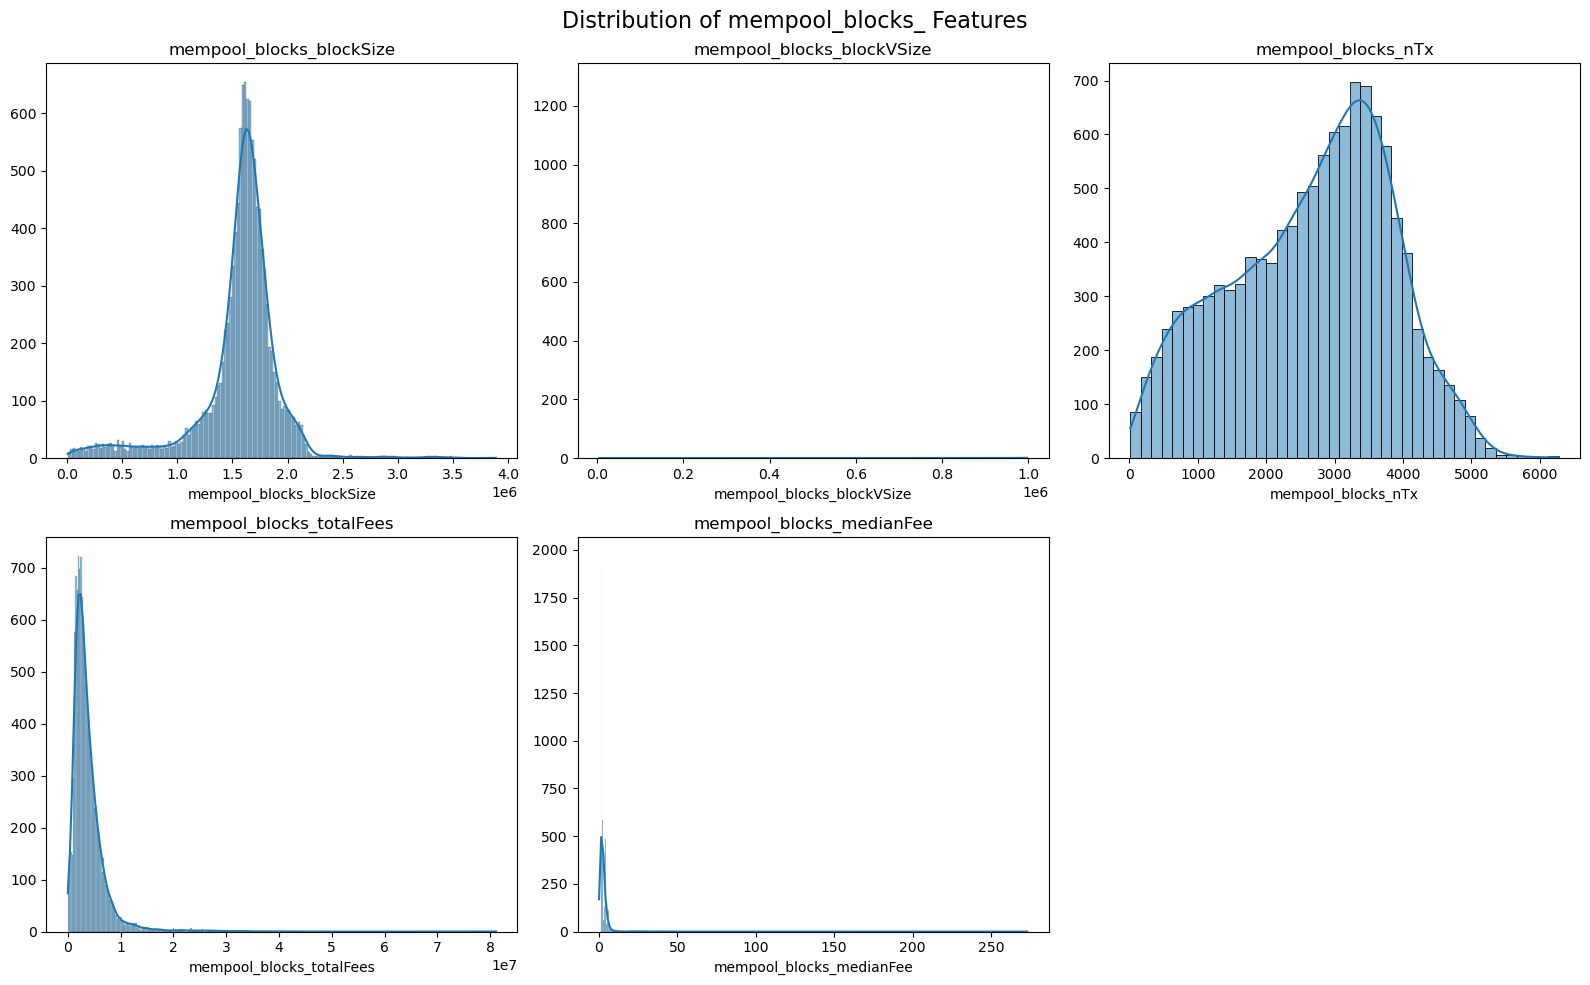

In [11]:
def plot_feature_group(df, prefix, max_cols=3, figsize=(16, 10)):
    group_cols = [col for col in df.columns if col.startswith(prefix)]
    n = len(group_cols)
    rows = (n + max_cols - 1) // max_cols
    fig, axes = plt.subplots(rows, max_cols, figsize=figsize, squeeze=False)
    
    for i, col in enumerate(group_cols):
        ax = axes[i // max_cols][i % max_cols]
        sns.histplot(df[col].dropna(), kde=True, ax=ax)
        ax.set_title(col)
        ax.set_ylabel("")
    for j in range(i+1, rows * max_cols):
        fig.delaxes(axes[j // max_cols][j % max_cols])

    fig.suptitle(f"Distribution of {prefix} Features", fontsize=16)
    fig.tight_layout()
    plt.show()

plot_feature_group(df, "mempool_blocks_")


#### 5.3 Mempool State Features

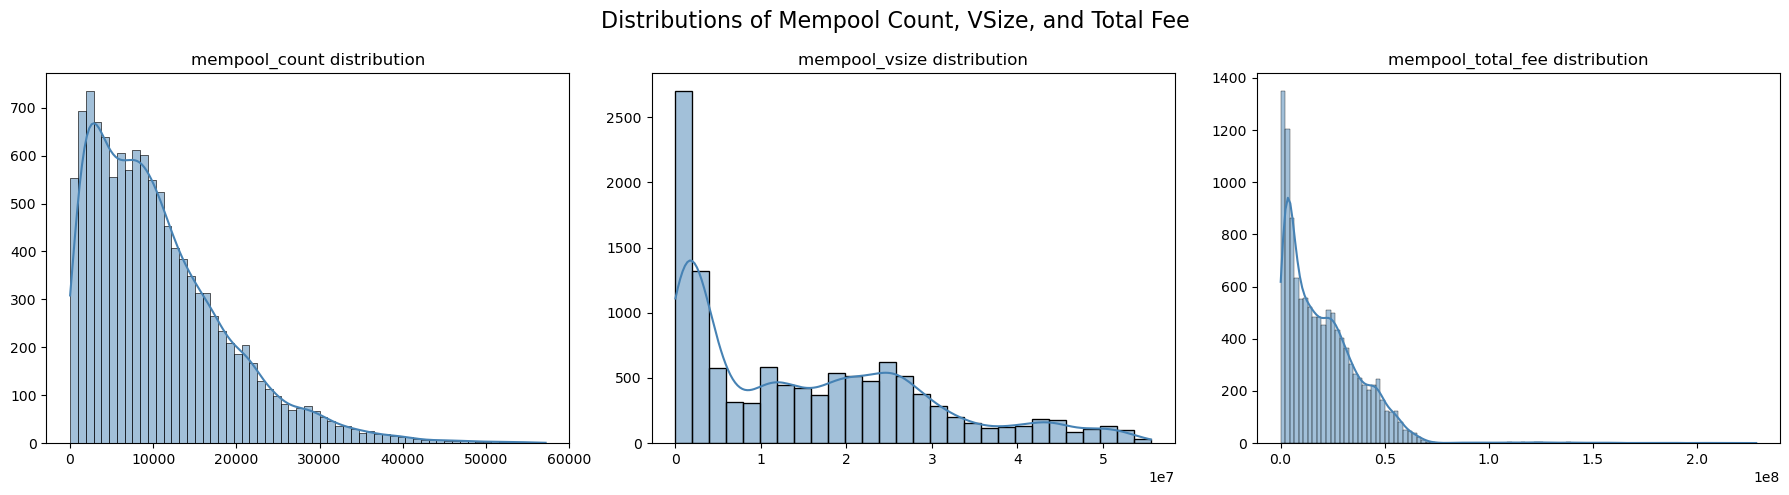

In [13]:
features = ["mempool_count", "mempool_vsize", "mempool_total_fee"]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns

for i, feature in enumerate(features):
    sns.histplot(df[feature].dropna(), kde=True, ax=axes[i], color="steelblue")
    axes[i].set_title(f"{feature} distribution")
    axes[i].set_ylabel("")
    axes[i].set_xlabel("")

fig.suptitle("Distributions of Mempool Count, VSize, and Total Fee", fontsize=16)
plt.tight_layout()
plt.show()

- `mempool_count`, `mempool_vsize` and `mempool_total_fee` all exhibit strong right-skewness with long tails.

- A log transformation or outlier trimming may help stabilize variance and improve model fit.


#### 5.4 Difficulty Adjustment Features

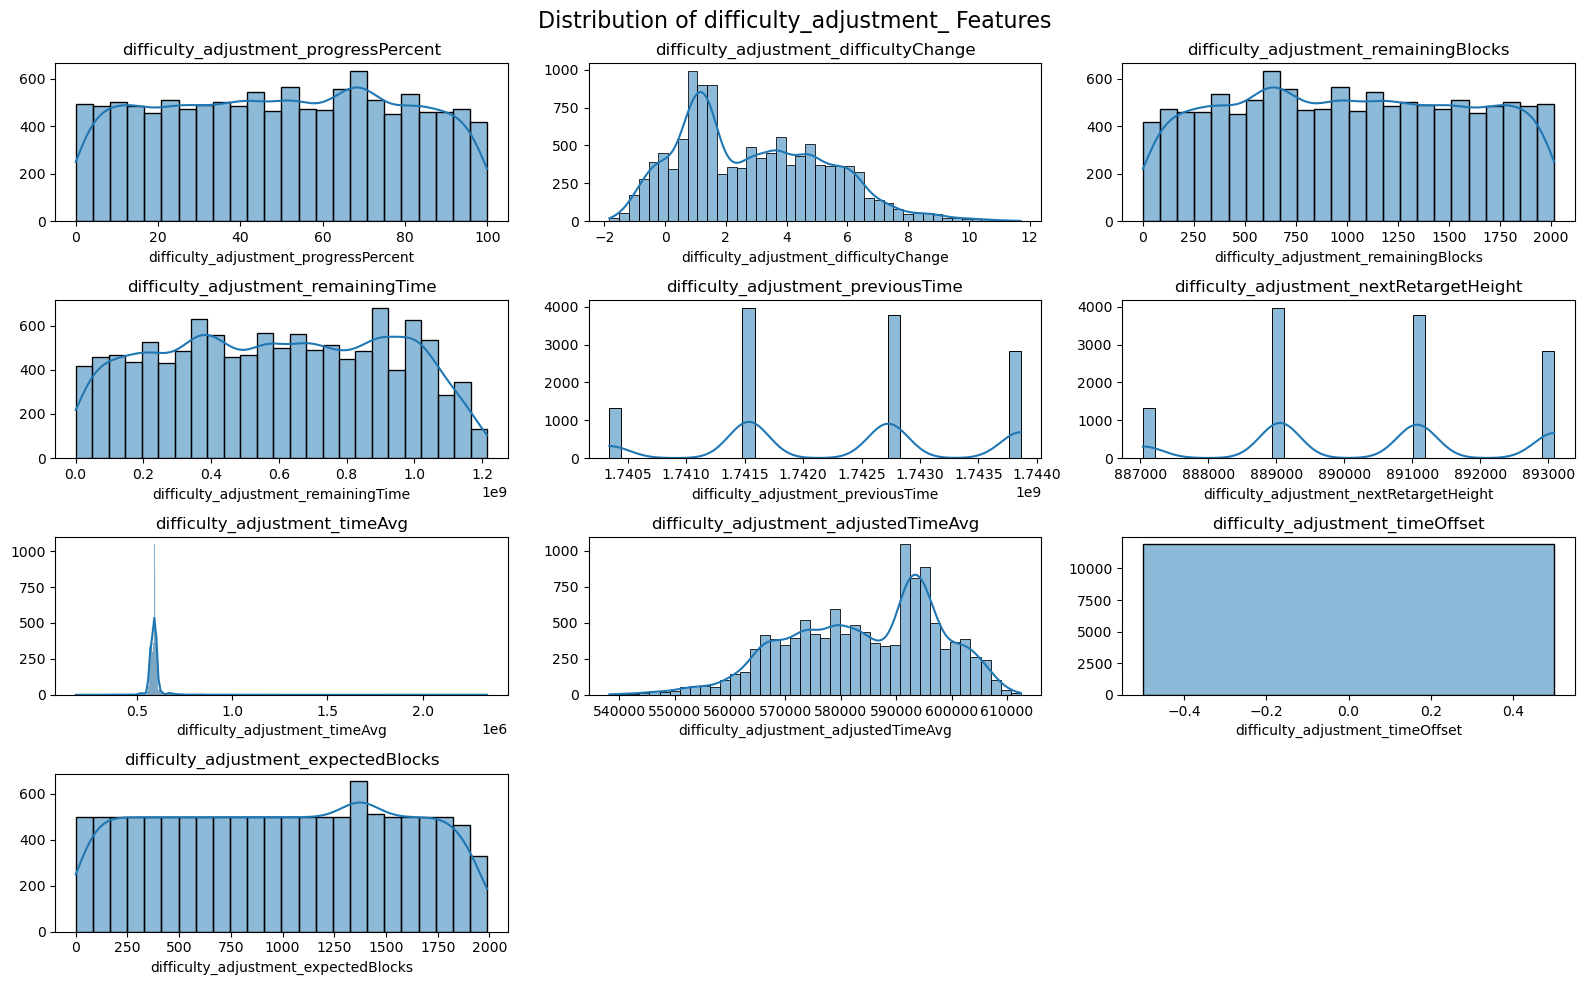

In [14]:
plot_feature_group(df, "difficulty_adjustment_")


- Features like `difficulty_adjustment_progressPercent` and `difficulty_adjustment_expectedBlocks` appear roughly uniform or multi-modal, reflecting variability across epochs.

- Discrete spikes in `previousTime` and `nextRetargetHeight` correspond to deterministic retarget boundaries—these may serve as useful epoch markers.

#### 5.5 Price Features

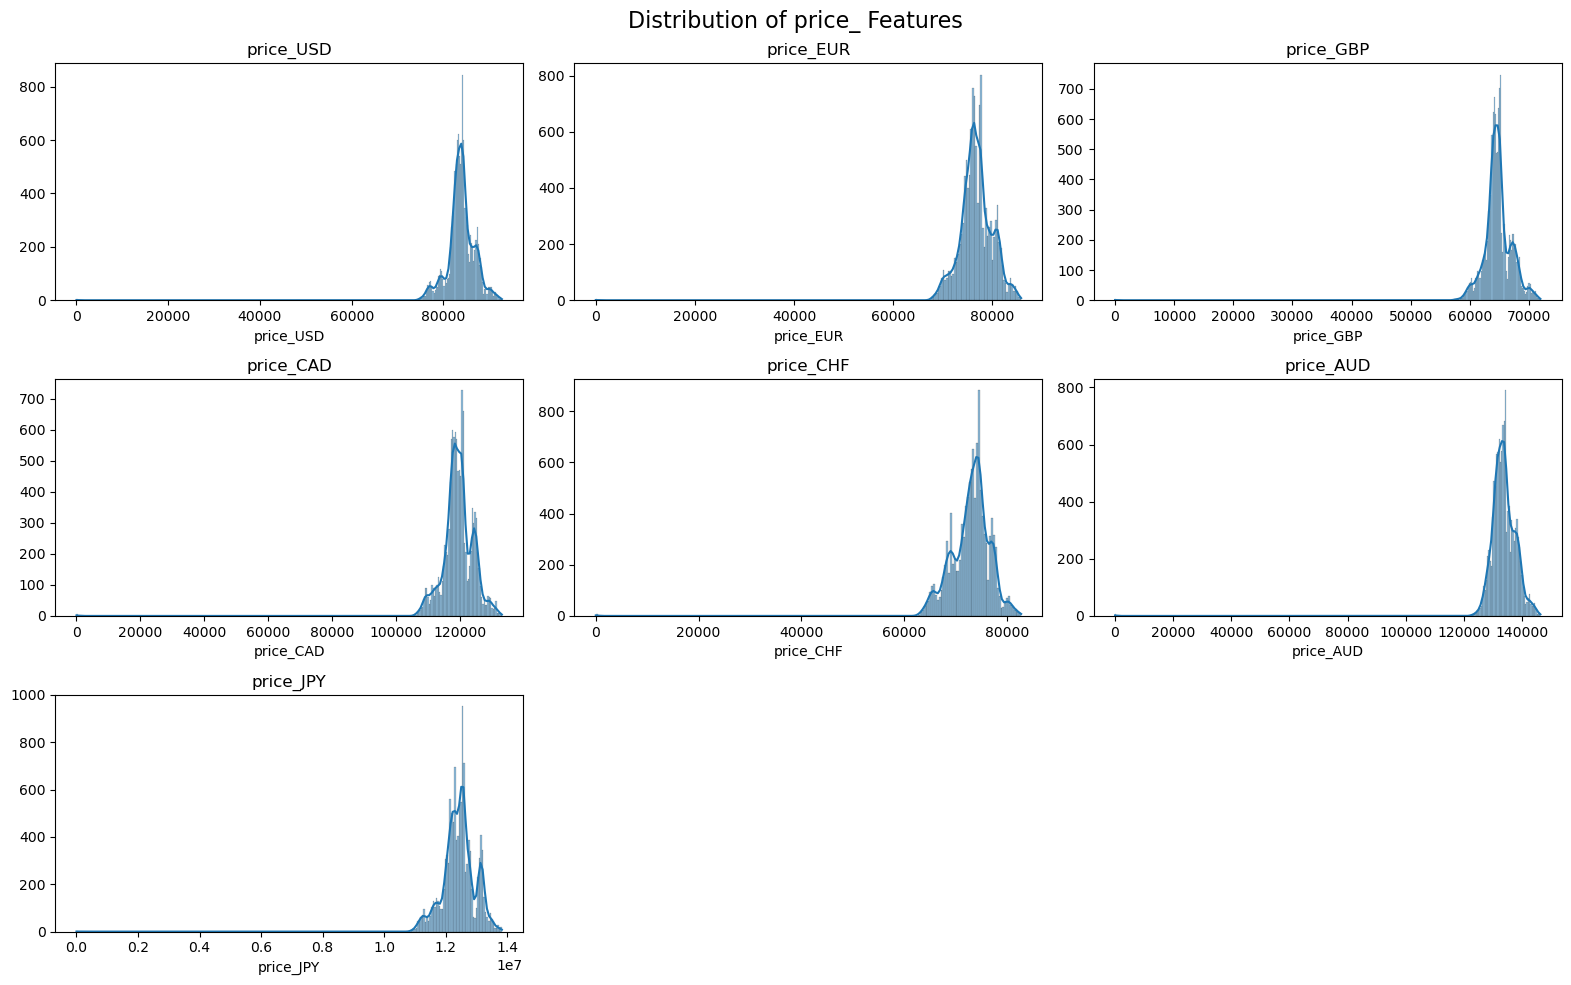

In [15]:
plot_feature_group(df, "price_")

- All currency prices (`price_USD`, `price_EUR`, …) cluster around narrow ranges with similar shapes, apart from four outlier points at –1 (handled earlier).

- Price series are relatively stable and can be treated as external covariates without additional transformation.

#### 5.6 Histogram Bin Features

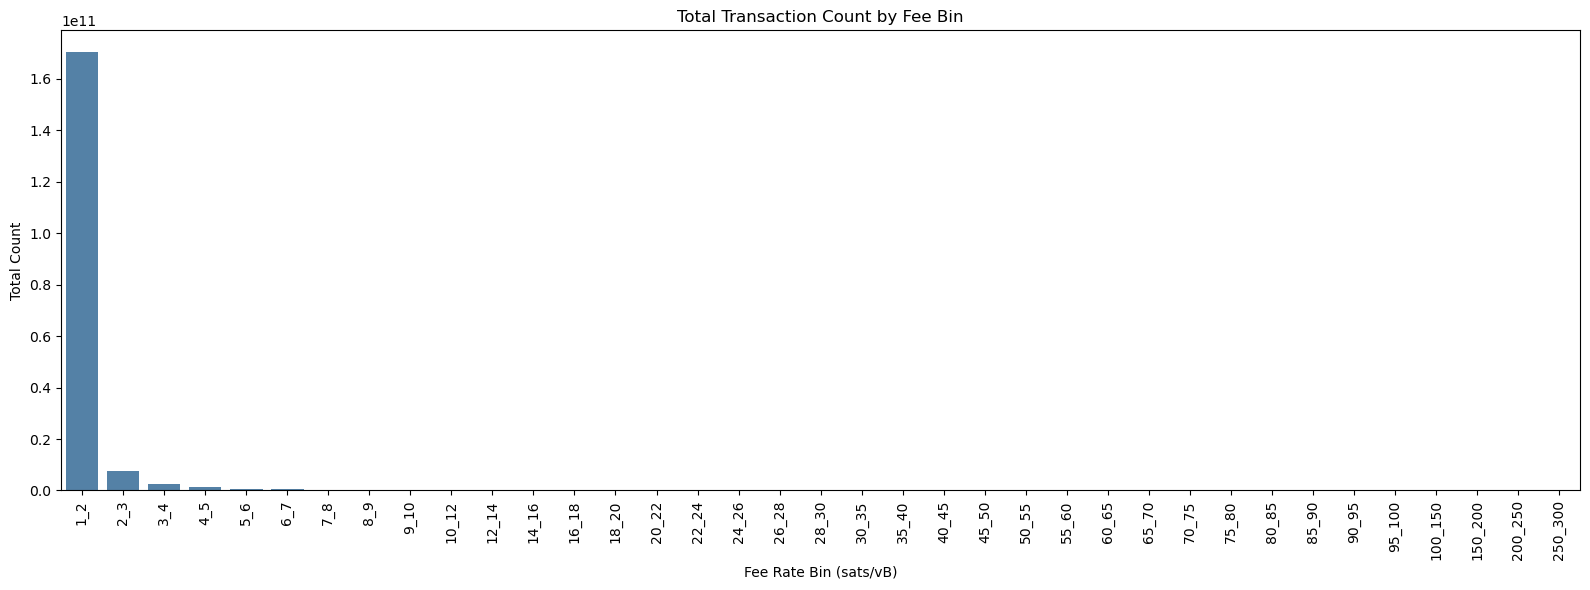

In [12]:
fee_cols = [col for col in df.columns if col.startswith("mempool_fee_histogram_bin_")]
total_per_bin = df[fee_cols].sum()
def extract_start(bin_name):
    return float(bin_name.split("_")[-2])
total_per_bin = total_per_bin.sort_values(key=lambda x: [extract_start(c) for c in x.index])
bin_labels = [col.replace("mempool_fee_histogram_bin_", "") for col in total_per_bin.index]
plt.figure(figsize=(16, 6))
sns.barplot(x=bin_labels, y=total_per_bin.values, color="steelblue")
plt.xticks(rotation=90)
plt.title("Total Transaction Count by Fee Bin")
plt.xlabel("Fee Rate Bin (sats/vB)")
plt.ylabel("Total Count")
plt.tight_layout()
plt.show()


- Roughly 92.5% of all transactions fall into the 1–2 sats/vB bin; including 2–3 sats/vB brings the cumulative share above 96%.

- Higher-fee bins are extremely sparse—consider merging rare bins or focusing only on the first few for modeling to reduce sparsity.

#### 5.7 Fee Bin Proportions

In [13]:
# Calculate the proportion of each bin's count relative to the total count
total_count = total_per_bin.sum()
bin_proportions = total_per_bin / total_count * 100
bin_proportions.head()

mempool_fee_histogram_bin_1_2    92.533407
mempool_fee_histogram_bin_2_3     4.155132
mempool_fee_histogram_bin_3_4     1.416449
mempool_fee_histogram_bin_4_5     0.678643
mempool_fee_histogram_bin_5_6     0.391679
dtype: float64

- Over 98% of all transactions fall into the 0–5 sats/vB range (92.5% in 1–2, 4.2% in 2–3, 1.4% in 3–4, 0.7% in 4–5 sats/vB).

- Bins above 5 sats/vB are extremely rare and could be aggregated or treated as “other” in downstream modeling to reduce sparsity.

#### 5.8 Log-Scaled Fee Bin Counts

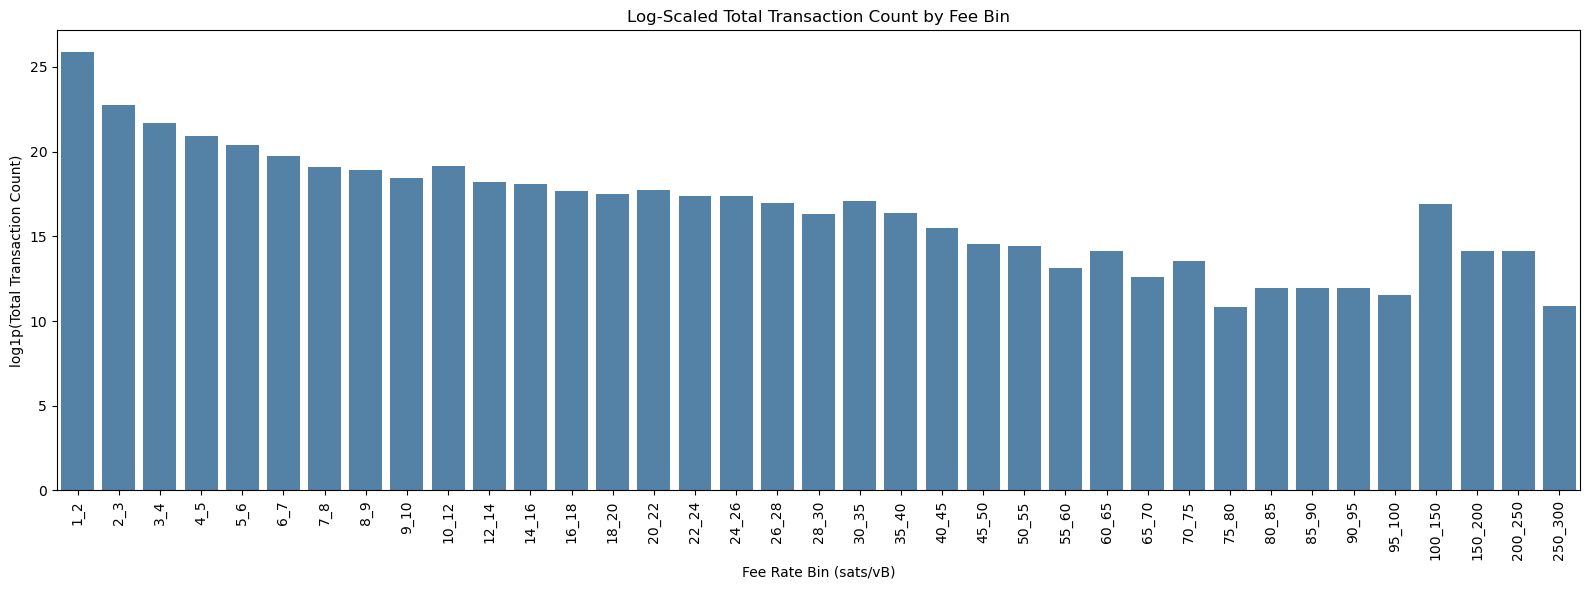

In [16]:
# Sum total transaction counts for each fee bin
fee_cols = [c for c in df.columns if c.startswith("mempool_fee_histogram_bin_")]
total_per_bin = df[fee_cols].sum()

# Extract numeric labels for plotting
bin_labels = [c.replace("mempool_fee_histogram_bin_", "") for c in total_per_bin.index]

# Apply log1p transformation to counts
log_counts = np.log1p(total_per_bin)

# Plot the log-scaled counts
plt.figure(figsize=(16, 6))
sns.barplot(x=bin_labels, y=log_counts.values, color="steelblue")
plt.xticks(rotation=90)
plt.xlabel("Fee Rate Bin (sats/vB)")
plt.ylabel("log1p(Total Transaction Count)")
plt.title("Log-Scaled Total Transaction Count by Fee Bin")
plt.tight_layout()
plt.show()

After applying the log₁p transform, the dominance of the 1–2 sats/vB bin is still clear, but the decline across higher bins appears much smoother. This view highlights that, although the vast majority of transactions occur at very low fees, there is meaningful activity extending up to around 20 sats/vB rather than an immediate drop to near zero.


### 6. Timestamp Coverage & Sampling

We check the overall time coverage and sampling interval of the dataset.

In [17]:
print("Start:", df.index.min())
print("End:", df.index.max())
print("Frequency mode:", df.index.to_series().diff().mode())

Start: 2025-03-05 02:14:41
End: 2025-04-15 09:54:42
Frequency mode: 0   0 days 00:05:00
Name: timestamp, dtype: timedelta64[ns]


The most frequent sampling interval is 5 minutes, but the data is not strictly regular. Many forecasting models assume evenly spaced time steps, so we may need to reindex and interpolate the data later depending on the model's required frequency. (e.g., ARIMA, TFT, DeepAR)

### 7. Trend and Seaonality of Fastest Fee

We explore the temporal structure of the target variable `recommended_fee_fastestFee` to identify possible long-term trends and short-term seasonality patterns.

To match the model input format, we use a 5-minute resampled time series, with daily periodicity (`period=288`).

#### 7.1 Additive Decomposition of Target Feature

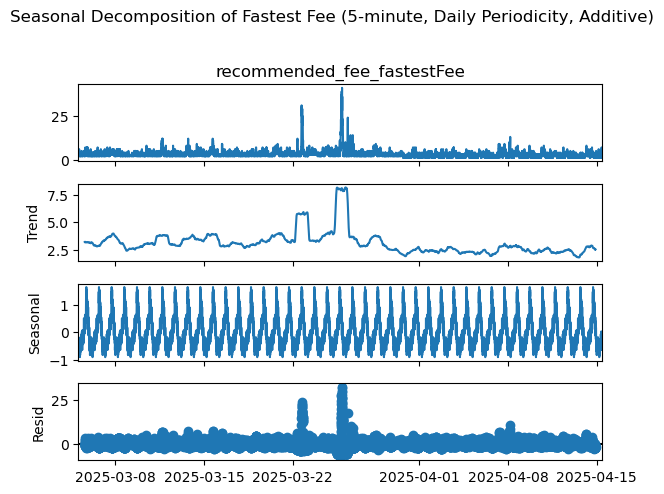

In [27]:
# Use 5-minute resampled data
# period=288 means 288 5-minute intervals = 1 day
decomp_result = seasonal_decompose(df["recommended_fee_fastestFee"], model='additive', period=288)
decomp_result.plot()
plt.suptitle("Seasonal Decomposition of Fastest Fee (5-minute, Daily Periodicity, Additive)", y=1.02)
plt.tight_layout()
plt.show()

We performed an additive decomposition on `recommended_fee_fastestFee` using a daily period (288 five-minute intervals).

- The trend component shows a gradual increase and a few prominent spikes, suggesting changing network demand over time.

- The seasonal component reveals a strong daily pattern, confirming periodicity in fee behavior.

- The residual component captures sharp local fluctuations and anomalies, particularly around March 22–25 and early April.

This result confirms that the fee rate exhibits clear trend and seasonality, and that decomposition can help isolate noise or unusual events for better forecasting.

#### 7.2 Multiplicative Decomposition of Target Feature

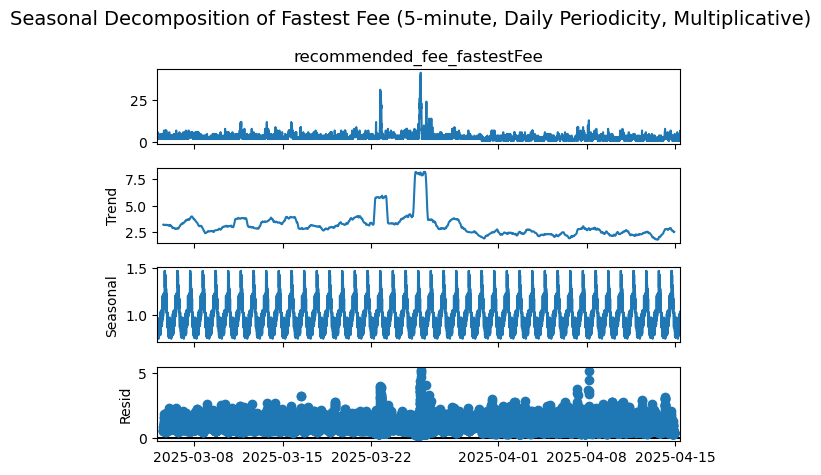

In [26]:
# Multiplicative decomposition using daily periodicity (288 intervals = 24 hours)
result_mul = seasonal_decompose(
    df["recommended_fee_fastestFee"],
    model="multiplicative",
    period=288
)

# Plot the decomposition
result_mul.plot()
plt.suptitle("Seasonal Decomposition of Fastest Fee (5-minute, Daily Periodicity, Multiplicative)", fontsize=14)
plt.tight_layout()
plt.show()

The multiplicative decomposition of `recommended_fee_fastestFee` reveals:

- A daily seasonality pattern with stable oscillations, confirming 24-hour trading cycles.
- A nonlinear trend showing a temporary fee spike in late March.
- Significant residual spikes suggest anomalous behavior or sudden congestion events not captured by seasonal or trend components.

This supports the use of time series models that account for both seasonality and event-driven outliers (e.g., Prophet, DeepAR).

### 8. Stationarity Checks of Target Feature

We examine whether the target time series is stationary using visual and statistical methods. Stationarity is a key assumption for many time series models such as ARIMA.

#### 8.1 Rolling Mean and Standard Deviation

We plot the rolling mean and standard deviation of the target feature to visually assess stationarity. A stationary series should have relatively constant mean and variance over time.

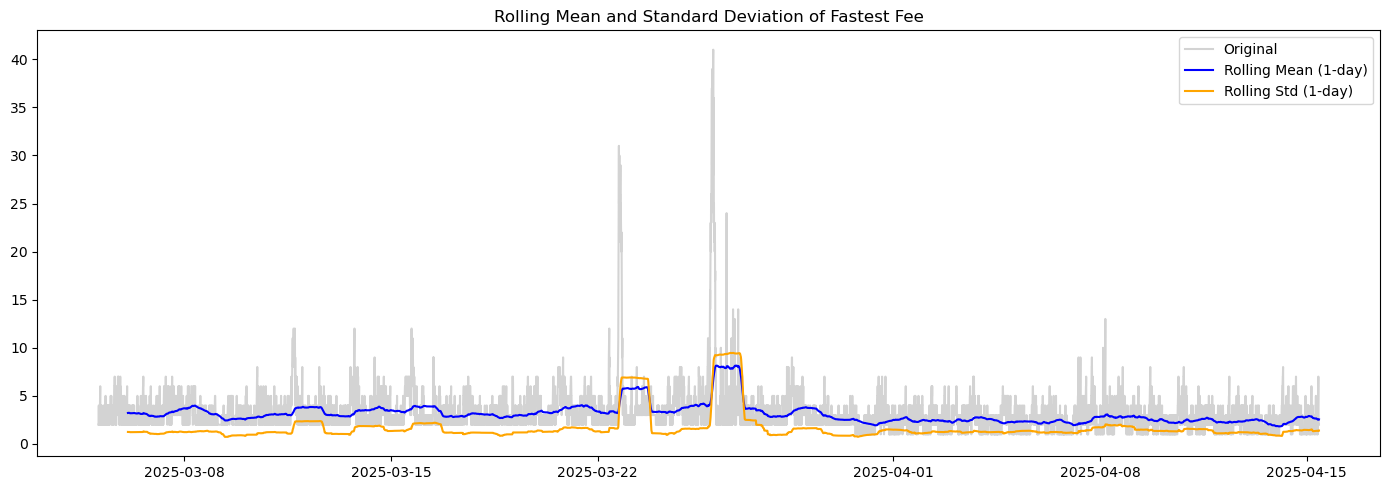

In [28]:
window = 288  # 1-day window for 5-min data

rolling_mean = df["recommended_fee_fastestFee"].rolling(window=window).mean()
rolling_std = df["recommended_fee_fastestFee"].rolling(window=window).std()

plt.figure(figsize=(14, 5))
plt.plot(df["recommended_fee_fastestFee"], color="lightgray", label="Original")
plt.plot(rolling_mean, color="blue", label="Rolling Mean (1-day)")
plt.plot(rolling_std, color="orange", label="Rolling Std (1-day)")
plt.title("Rolling Mean and Standard Deviation of Fastest Fee")
plt.legend()
plt.tight_layout()
plt.show()

The plot shows:

- The rolling mean (blue) and rolling standard deviation (orange) exhibit noticeable variation over time.

- There are visible trends and changes in variability, especially around the March 22–24 spike and early April, indicating non-stationarity in both the mean and variance.

- This suggests that differencing or transformation may be required before fitting models that assume stationarity (e.g., ARIMA).

#### 8.2 Augmented Dickey-Fuller (ADF) Test

We perform the Augmented Dickey-Fuller (ADF) test to assess the stationarity of the `recommended_fee_fastestFee` series. Understanding whether the series is stationary helps inform the choice of appropriate modeling techniques in subsequent steps.


In [30]:
# Perform ADF test on the target feature
adf_result = adfuller(df["recommended_fee_fastestFee"].dropna())

print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
for key, value in adf_result[4].items():
    print(f"Critical Value ({key}): {value:.4f}")

ADF Statistic: -13.202832709143335
p-value: 1.0856781363203985e-24
Critical Value (1%): -3.4309
Critical Value (5%): -2.8618
Critical Value (10%): -2.5669


The ADF test result shows a test statistic of -13.20, which is significantly lower than all critical values at the 1%, 5%, and 10% levels. The p-value is effectively zero (1.08e-24).

This provides strong evidence to reject the null hypothesis of non-stationarity, suggesting that the `recommended_fee_fastestFee` series is statistically stationary in its current form.

Combined with previous decomposition results, which revealed both clear daily seasonality and a non-linear trend, this result implies that models capable of handling **stationary but seasonally structured** time series may be appropriate.

Therefore, we may consider models such as ARIMA, SARIMA, or seasonality-aware machine learning models in the next stage, depending on how well they capture the observed temporal patterns.

Since the series is already stationary, no differencing is required before applying time series models that assume a stationary input.


#### 8.3 ACF and PACF of Target Feature
We visualize autocorrelation patterns to support lag structure analysis.

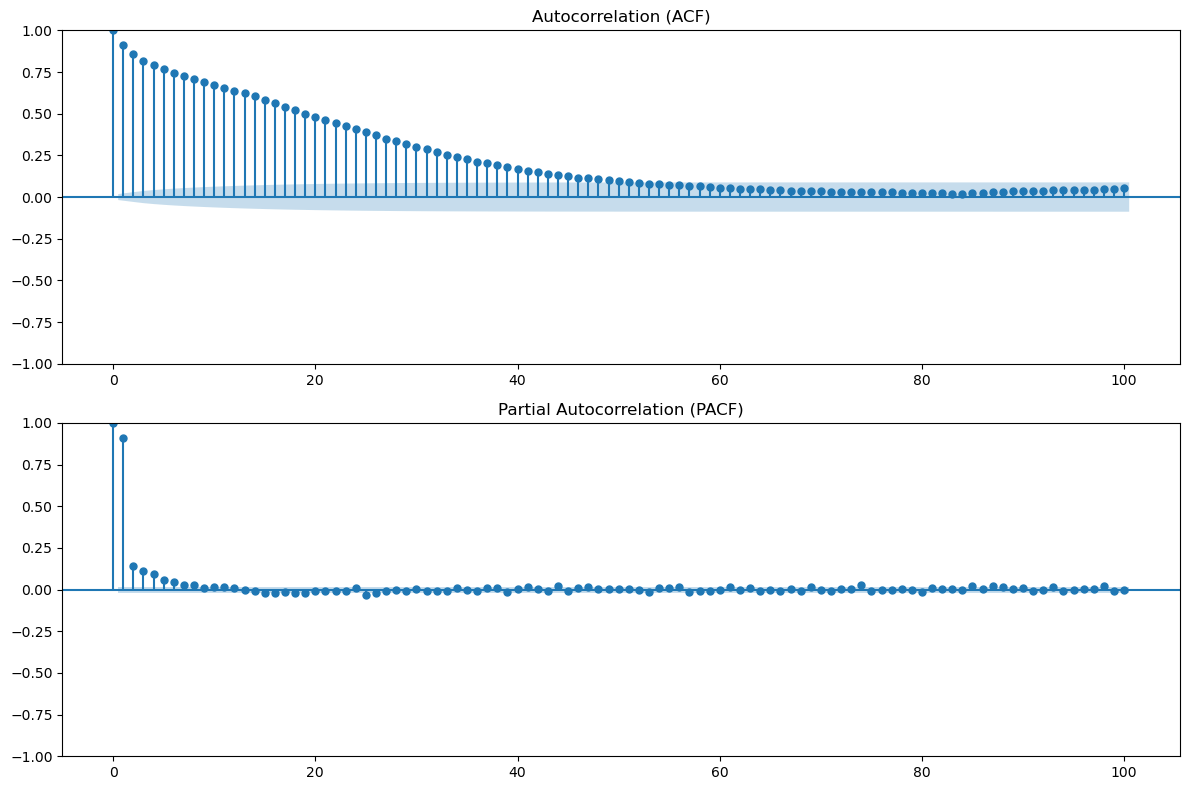

In [32]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df["recommended_fee_fastestFee"].dropna(), ax=ax[0], lags=100, title="Autocorrelation (ACF)")
plot_pacf(df["recommended_fee_fastestFee"].dropna(), ax=ax[1], lags=100, title="Partial Autocorrelation (PACF)")
plt.tight_layout()
plt.show()

The ACF plot shows a slow exponential decay, indicating significant autocorrelation over many lags.
The PACF plot drops sharply after lag 2, suggesting that the majority of the direct autoregressive relationship is captured within the first 2 lags.

This pattern is consistent with an autoregressive process (AR) of order 2.
That means models like AR(2) or ARIMA(p=2, d=0, q=...) may be reasonable starting points.
The presence of long-lag autocorrelation in ACF also supports exploring seasonal models (e.g., SARIMA, TFT).

### 8. Correlation Heatmap

We visualize the correlation among feature groups using heatmaps.

In [18]:
group_prefixes = {
    # "mempool_blocks": "mempool_blocks_",
    "recommended_fee": "recommended_fee_",
    "mempool": "mempool_",
    "difficulty_adjustment": "difficulty_adjustment_",
    "price": "price_"
}
excluded_prefixes = ["mempool_fee_histogram_"]
def plot_group_correlation(df, group_name, prefix, exclude_prefixes=None):
    # Select columns matching prefix
    group_cols = [col for col in df.columns if col.startswith(prefix)]
    
    # Exclude anything that starts with excluded prefixes
    if exclude_prefixes:
        group_cols = [col for col in group_cols if not any(col.startswith(ex) for ex in exclude_prefixes)]

    # Drop NA for correlation
    group_df = df[group_cols].dropna()

    # Skip if not enough features
    if len(group_cols) < 2:
        print(f"Skipping group '{group_name}' — fewer than 2 valid columns.")
        return

    # Compute correlation
    corr = group_df.corr()

    # Shorten columns that start with 'difficulty_adjustment_' to 'diff_adj_'
    corr.columns = [col.replace("difficulty_adjustment_", "diff_adj_") for col in corr.columns]
    corr.index = [col.replace("difficulty_adjustment_", "diff_adj_") for col in corr.index]

    # Plot
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0, square=True)
    plt.title(f"{group_name} Feature Correlation")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


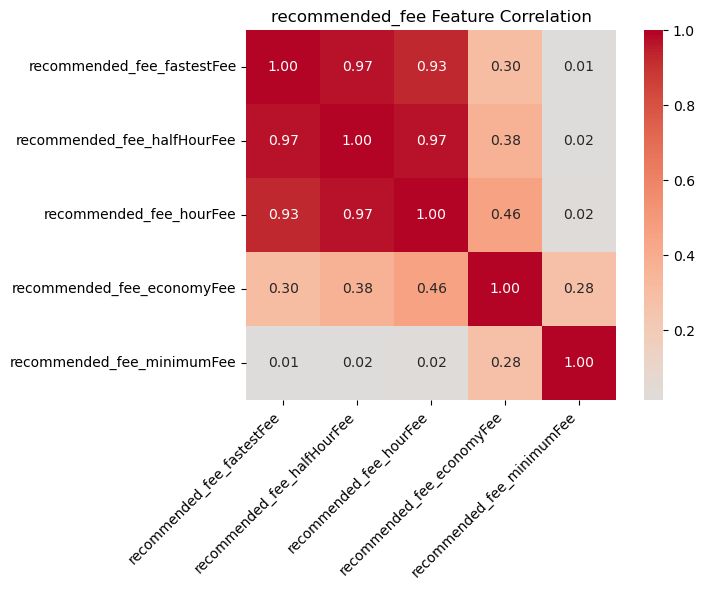

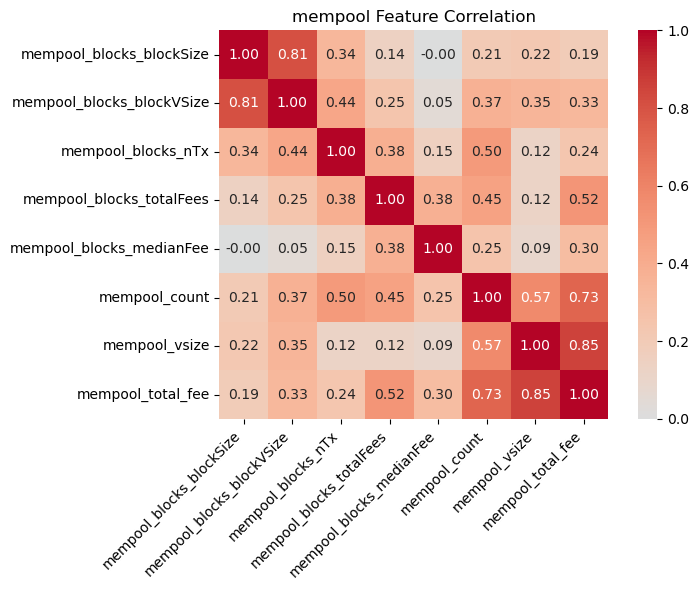

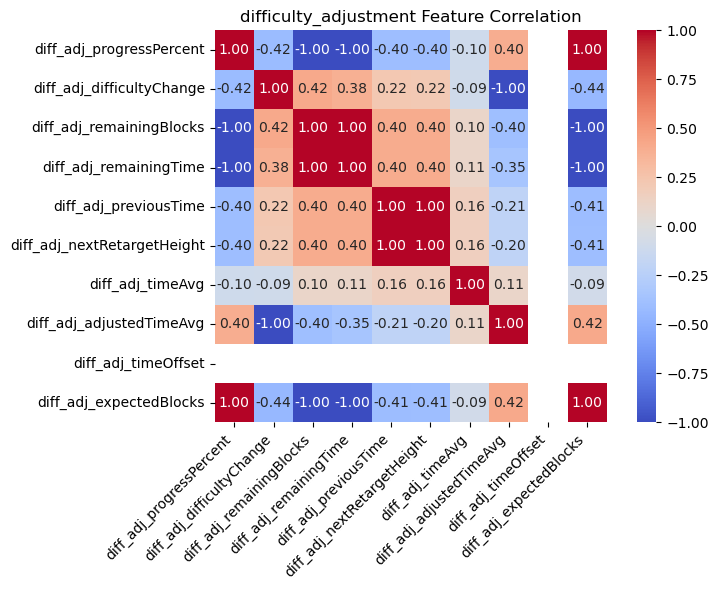

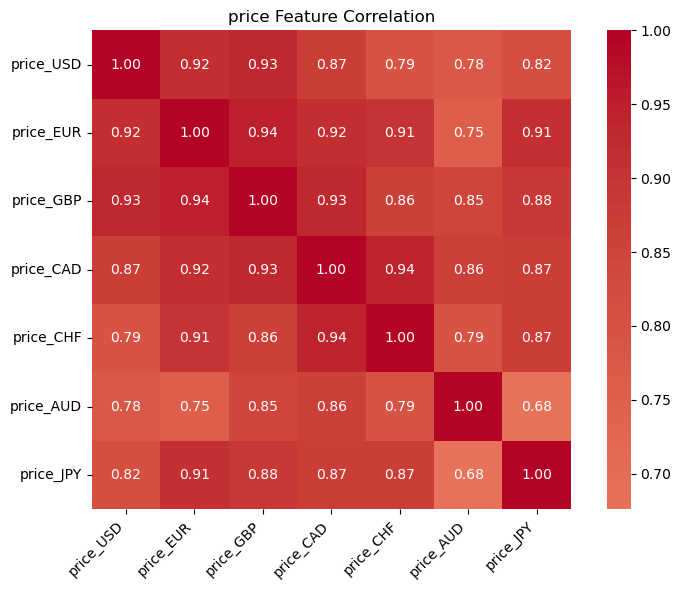

In [19]:
for group_name, prefix in group_prefixes.items():
    plot_group_correlation(df, group_name, prefix, exclude_prefixes = excluded_prefixes)


The correlation heatmaps reveal several important relationships:

- Recommended fees like `fastestFee`, `halfHourFee`, and `hourFee` are highly correlated (ρ > 0.9), suggesting they track similar market dynamics.

- Mempool size and total fee (`mempool_vsize`, `mempool_total_fee`) are strongly correlated, while `medianFee` is weakly correlated with most other variables.

- Difficulty adjustment features include many exact or inverse relationships, reflecting the internal mechanics of Bitcoin's difficulty retargeting.

- BTC prices across currencies are also highly correlated due to stable exchange rates.

These insights help us identify potential multicollinearity, guide feature selection, and motivate dimensionality reduction if needed.

### 9. Key features

#### 9.1 Summary Table of Selected Features

Since our goal is to forecast fee rates, the key features should be those that are:

1. Directly Related to Fee Behavior
Influence how fees are set or how congestion builds up
Reflect network load or transaction priority dynamics
2. Useful for Forecasting Time Series
Time-varying
Available in real-time or known into the future

| Category                | Features                                                                                      | Why Important?                                                                                      |
|-------------------------|-----------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------------|
| Target & Fee Estimates  | `recommended_fee_fastestFee`, `recommended_fee_halfHourFee`, `recommended_fee_hourFee`, `recommended_fee_economyFee`, `recommended_fee_minimumFee` | These are the predicted targets (or close variants), and how the mempool system estimates current rates |
| Mempool Congestion      | `mempool_count`, `mempool_vsize`, `mempool_total_fee`                                        | Reflect the real-time network load and pending demand                                              |
| Block Characteristics   | `mempool_blocks_blockSize`, `mempool_blocks_blockVSize`, `mempool_blocks_nTx`, `mempool_blocks_totalFees`, `mempool_blocks_medianFee` | Describe current mining block shape and behavior                                                  |
| Difficulty Signals      | `difficulty_adjustment_remainingBlocks`, `difficulty_adjustment_difficultyChange`, `difficulty_adjustment_adjustedTimeAvg` | Affect block production pace and expected fee demand                                              |
| Market Prices           | `price_USD`, `price_CAD`, `price_EUR`, etc.                                                   | May capture global market sentiment and volume, though likely weak correlates unless fees are fiat-tied |



#### 9.2 Distributions of Selected Features

We visualize the distribution of selected key features to assess skewness, potential outliers, and feature variability. This helps determine if any transformation (e.g., log) may be beneficial before modeling.

In [20]:
key_features = [
    # fee estimates
    "recommended_fee_fastestFee",
    "recommended_fee_halfHourFee",
    "recommended_fee_hourFee",
    "recommended_fee_economyFee",
    "recommended_fee_minimumFee",
    
    # mempool state
    "mempool_count",
    "mempool_vsize",
    "mempool_total_fee",
    
    # block metrics
    "mempool_blocks_blockSize",
    "mempool_blocks_blockVSize",
    "mempool_blocks_nTx",
    "mempool_blocks_totalFees",
    "mempool_blocks_medianFee",
    
    # difficulty signals (select most relevant)
    "difficulty_adjustment_remainingBlocks",
    "difficulty_adjustment_difficultyChange",
    "difficulty_adjustment_adjustedTimeAvg",
    
    # market signal 
    "price_USD"
]


In [21]:
def plot_distributions(columns, cols_per_row=3):
    rows = int(np.ceil(len(columns) / cols_per_row))
    fig, axes = plt.subplots(rows, cols_per_row, figsize=(6 * cols_per_row, 4 * rows))
    axes = axes.flatten()

    for i, col in enumerate(columns):
        sns.histplot(df[col].dropna(), kde=True, ax=axes[i], color="cornflowerblue")
        axes[i].set_title(col, fontsize=11)
        axes[i].set_ylabel("")
        axes[i].set_xlabel("")
    
    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle("Key Feature Distributions (excluding histogram bins)", fontsize=16)
    fig.tight_layout()
    plt.show()

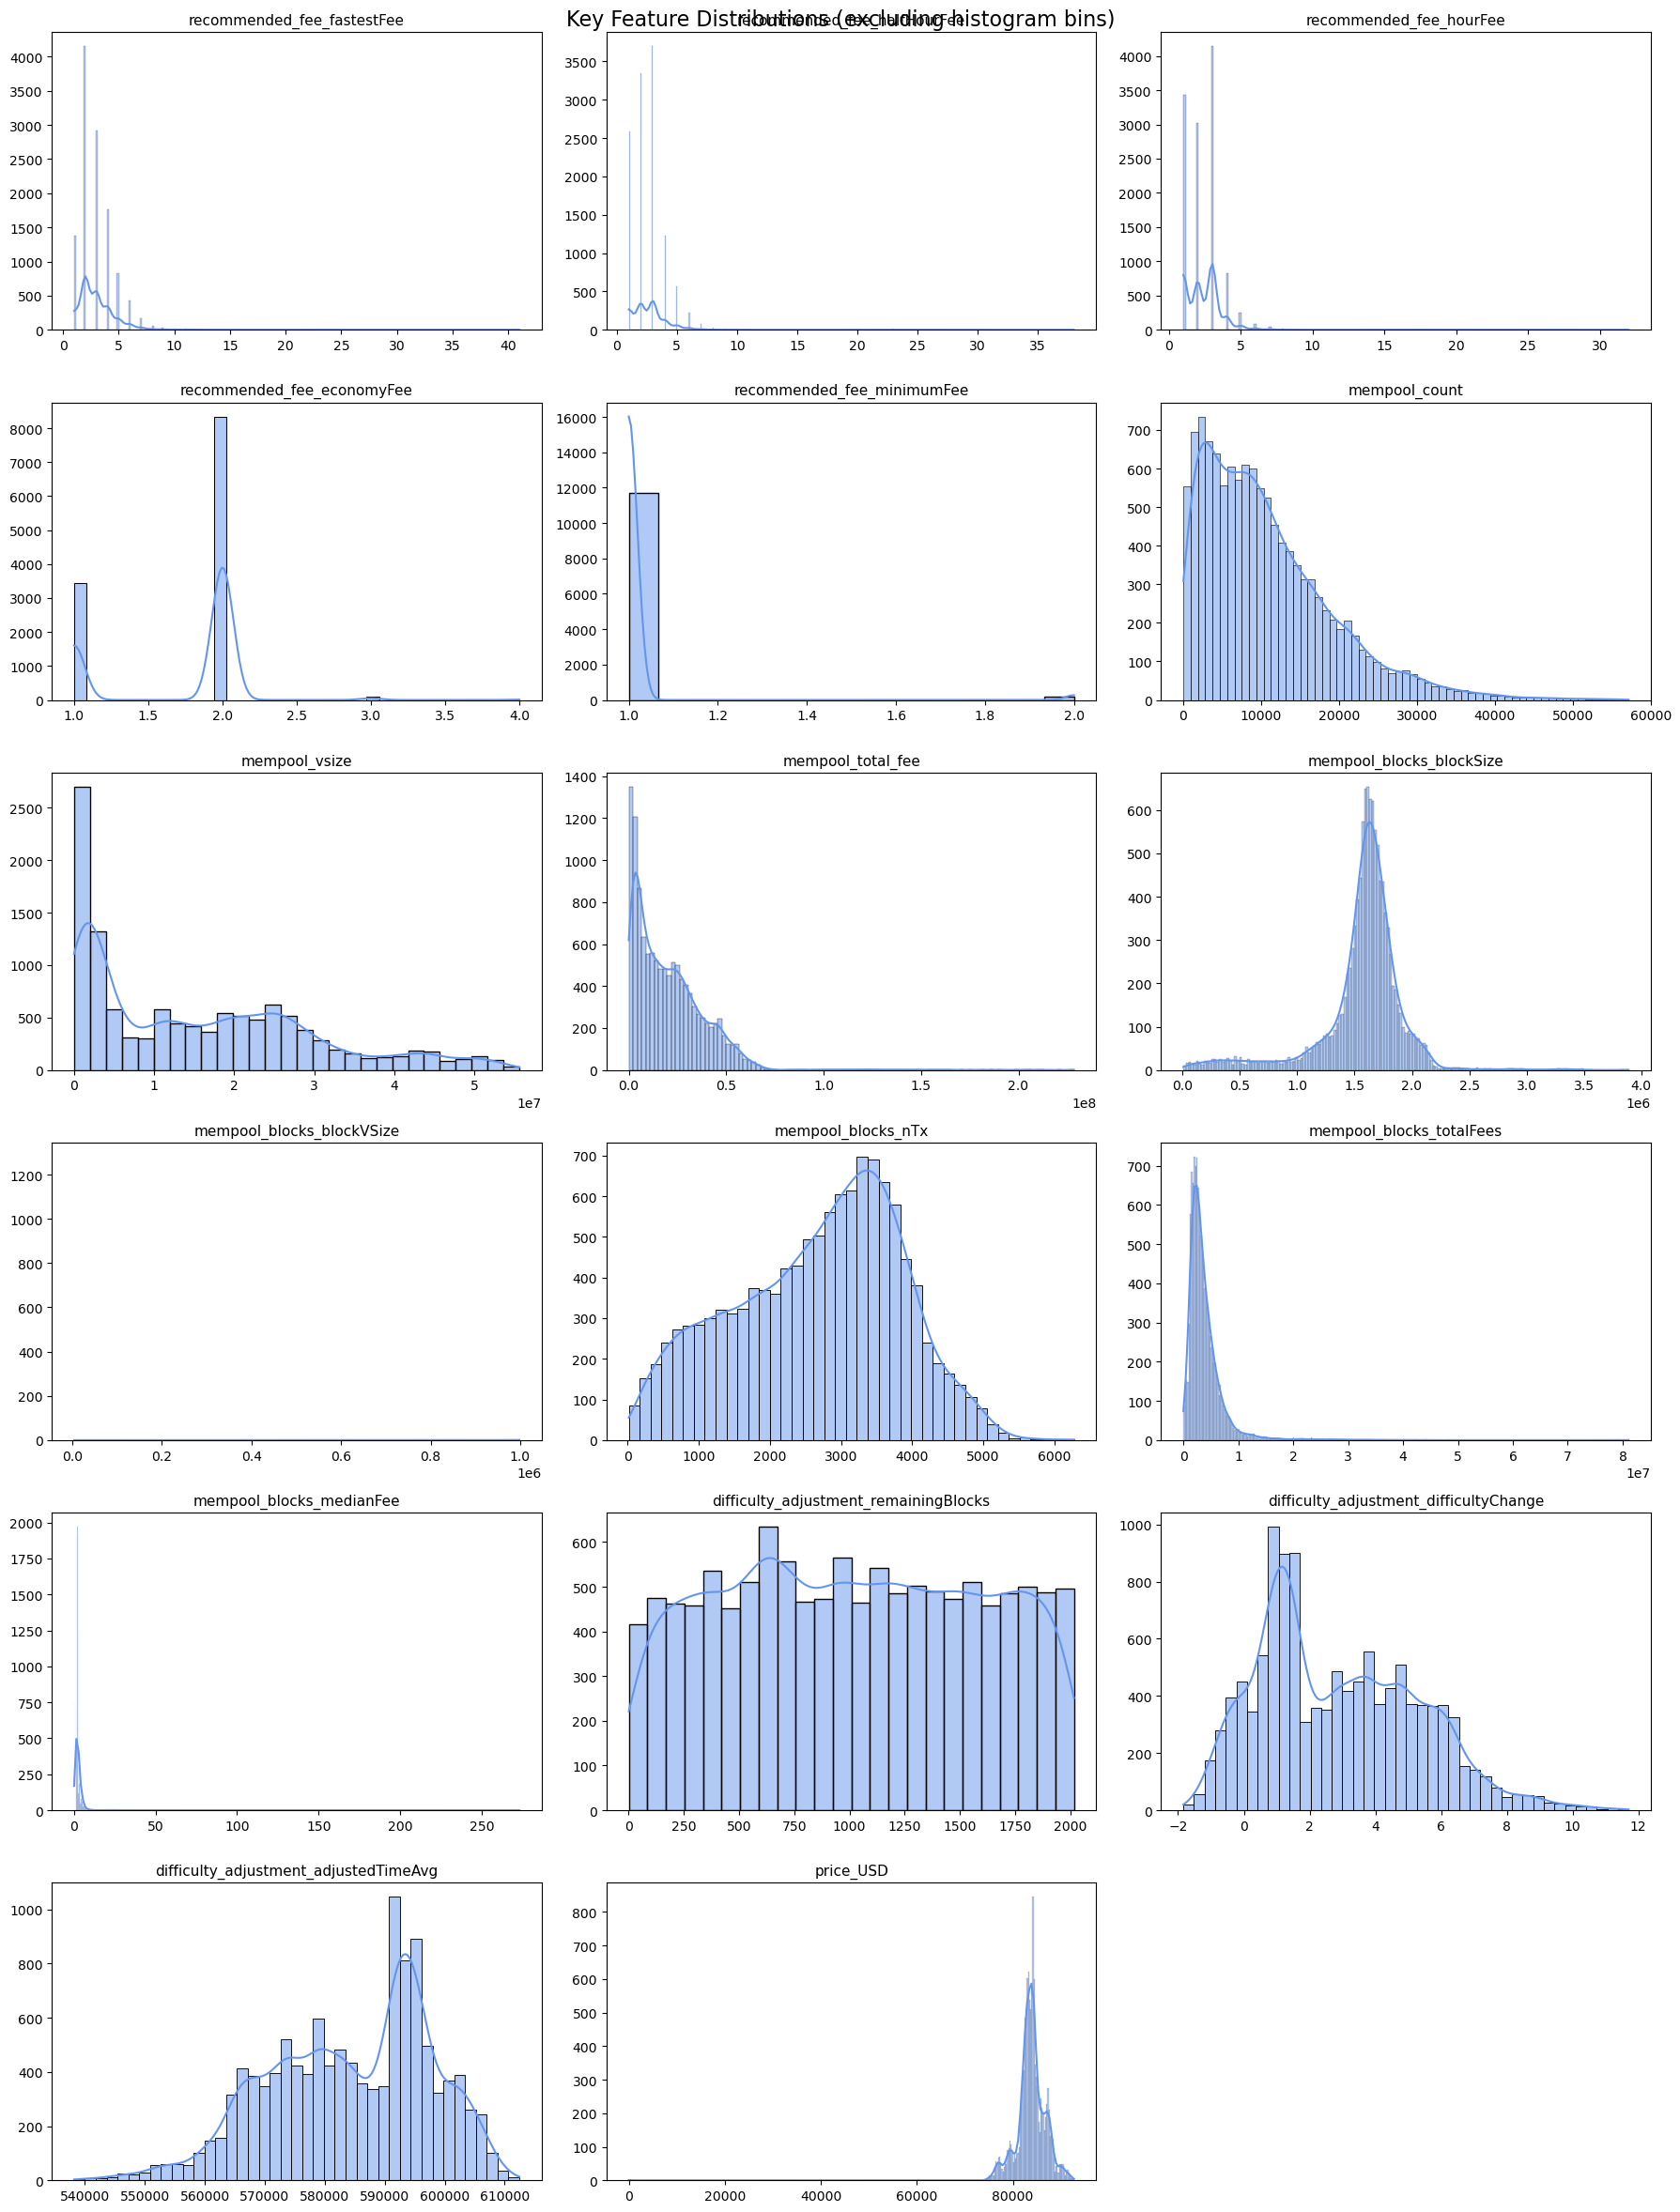

In [22]:
plot_distributions(key_features)


This section identifies the most relevant features for forecasting transaction fee rates. These include direct fee estimates, mempool congestion indicators, mining block characteristics, difficulty adjustment signals, and market prices.
The visual inspection shows that many of these features are highly skewed (e.g., `recommended_fee_fastestFee`, `mempool_total_fee`), suggesting the potential need for transformation (e.g., log-scaling) in modeling.
This curated set of features will guide the baseline and advanced forecasting models in subsequent stages.